In [25]:
%matplotlib inline

from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import numpy as np
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from matplotlib import pyplot as plt

import pandas as pd
import pyaudio

In [26]:
sample_rate = 2048

train_labels = pd.read_csv("./g2net-gravitational-wave-detection/training_labels_with_paths.csv")
train_labels.target.value_counts()

0    280070
1    279930
Name: target, dtype: int64

In [27]:
def plot_time_data(d1, d2, d3, separate=True):
    plot = Plot(d1, d2, d3, separate=separate, sharex=True, figsize=[12, 8])
    ax = plot.gca()
    ax.set_xlim(0,2)
    ax.set_xlabel('Time [s]')
    plot.show()
    
def read_data_id(file_id):
    data_list = np.load(train_labels[train_labels.id==file_id].iloc[0].filepath)
    
    return [TimeSeries(data, sample_rate=sample_rate) for data in data_list]
    
def read_data(index, target):
    print(train_labels[train_labels.target==target].iloc[index].filepath)
    data_list = np.load(train_labels[train_labels.target==target].iloc[index].filepath)
    
    return [TimeSeries(data, sample_rate=sample_rate) for data in data_list]

def read_file(fname):
    data_list = np.load(fname)
    
    return [TimeSeries(data, sample_rate=sample_rate) for data in data_list]

def get_fname(file_id):
    return train_labels[train_labels.id==file_id].iloc[0].filepath
    
def correct(row):
    return row["filepath"].replace("/kaggle/input", ".")

In [28]:
train_labels["filepath"] = train_labels.apply(correct, axis=1)

# Raw Data

/usr/local/anaconda3/envs/GravWave/lib/python3.7/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


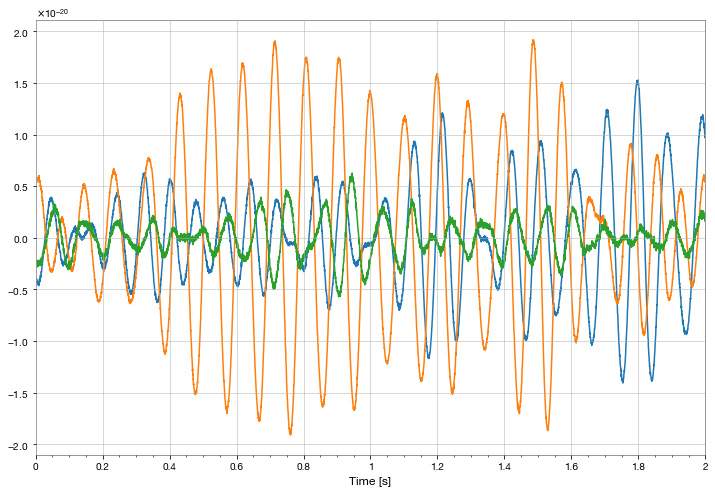

In [29]:
strain = read_data_id("000a5b6e5c")

strain[1].shift('6.9ms')
strain[1] *= -1

plot_time_data(*strain, separate=False)

# Tukey Windowed Data

/usr/local/anaconda3/envs/GravWave/lib/python3.7/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


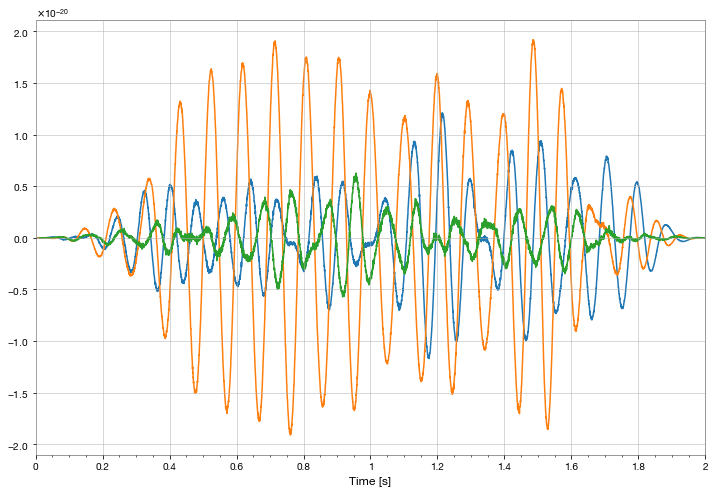

In [30]:
window = signal.tukey(sample_rate*2)

strain = read_data_id("000a5b6e5c")

strain[1].shift('6.9ms')
strain[1] *= -1

strain[2].shift('12ms')


strain = strain[0] * window, strain[1] * window, strain[2] * window

plot_time_data(*strain, separate=False)

# Rayleigh Spectrum

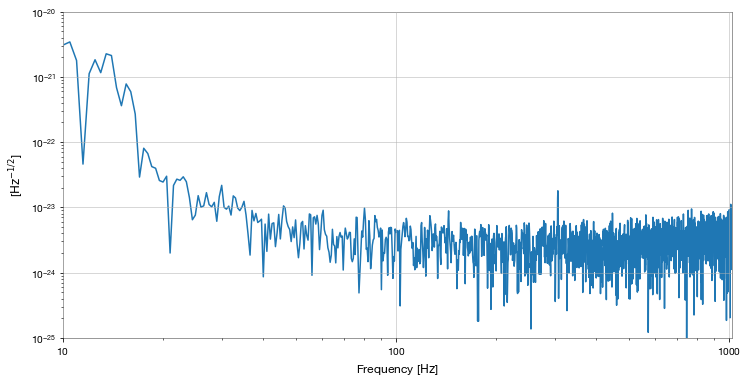

In [31]:
fig2 = strain[0].asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

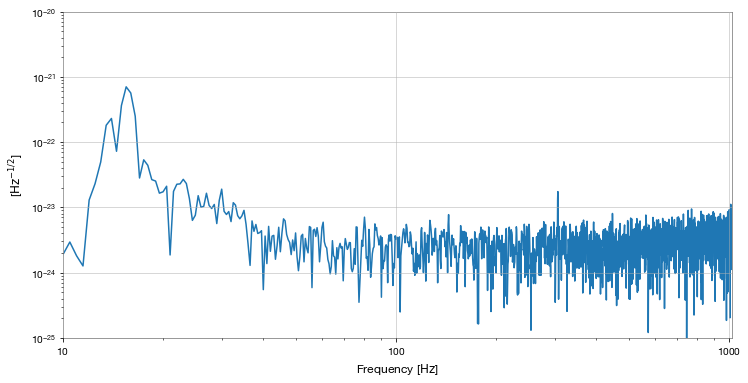

In [32]:
fig2b = strain[0].highpass(15).asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

# Whiten the data

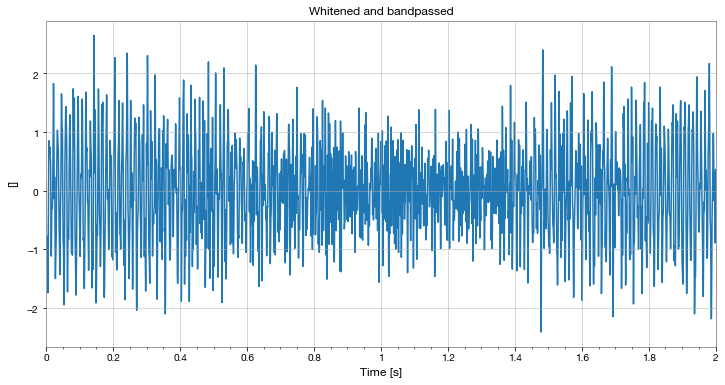

In [33]:
white_data = strain[0].whiten(window=("tukey",0.2))

bp_data = white_data.bandpass(35, 350)

fig3 = bp_data.plot(figsize=[12, 6])
plt.xlim(0, 2)
ax = plt.gca()
ax.set_title('Whitened and bandpassed')
ax.set_xlabel('Time [s]');

# Preprocess function

In [34]:
def preprocess(d1, d2, d3, bandpass=False, lf=35, hf=350, crop=True):
    duration = 0.25
    
    white_d1 = d1.whiten(window=("tukey",0.2), fduration=duration)
    white_d2 = d2.whiten(window=("tukey",0.2), fduration=duration)
    white_d3 = d3.whiten(window=("tukey",0.2), fduration=duration)
    
    if crop:
        white_d1 = white_d1.crop(duration, 2 - duration)
        white_d2 = white_d2.crop(duration, 2 - duration)
        white_d3 = white_d3.crop(duration, 2 - duration)
    
    #Shifting
    white_d1.shift('6.9ms')
    white_d1 *= -1
    
    white_d2.shift('12ms')
    
    if bandpass: # bandpass filter
        bp_d1 = white_d1.bandpass(lf, hf) 
        bp_d2 = white_d2.bandpass(lf, hf)
        bp_d3 = white_d3.bandpass(lf, hf)
        return bp_d1, bp_d2, bp_d3
    else: # only whiten
        return white_d1, white_d2, white_d3

# Play As Audio

./g2net-gravitational-wave-detection/train/0/0/0/00001f4945.npy
[-0.08120319  0.13167732  0.19748112 ...  0.20658272  0.17098659
 -0.04348083]


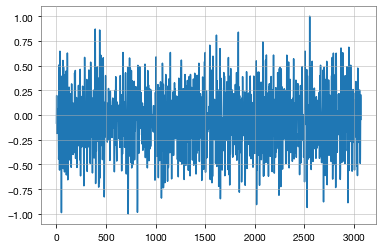

In [56]:
p = pyaudio.PyAudio()

volume = 0.5
duration = 2
f = 440
fs = 4410

def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

strain = read_data(0, 0)
processed_strain = preprocess(*strain, bandpass=True)

samples = (scale(np.array(processed_strain[2])) * 2 - 1)
print(samples)
samples.astype(np.float32)

# for paFloat32 sample values must be in range [-1.0, 1.0]
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=int(sample_rate),
                output=True)

# generate samples, note conversion to float32 array
# samples = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)

# play. May repeat with different volume values (if done interactively) 
# stream.write(volume*samples)

# stream.stop_stream()
# stream.close()

# p.terminate()

# plt.plot(samples)

/usr/local/anaconda3/envs/GravWave/lib/python3.7/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


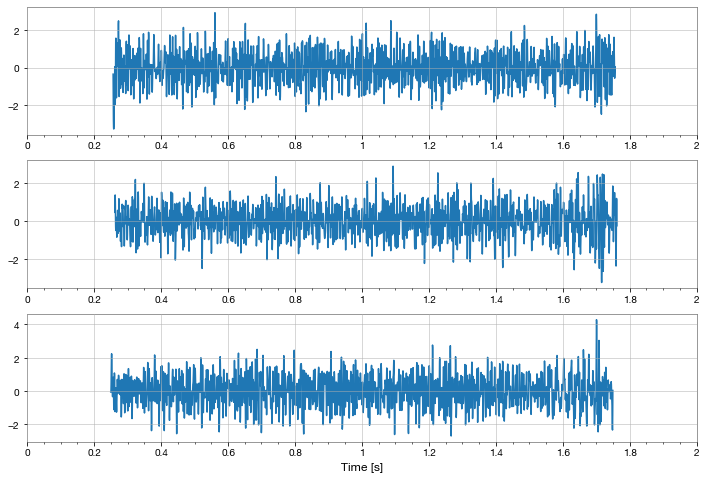

In [172]:
strain = read_data_id("000a5b6e5c")

processed_strain = preprocess(*strain, bandpass=True)

plot_time_data(*processed_strain, separate=True)

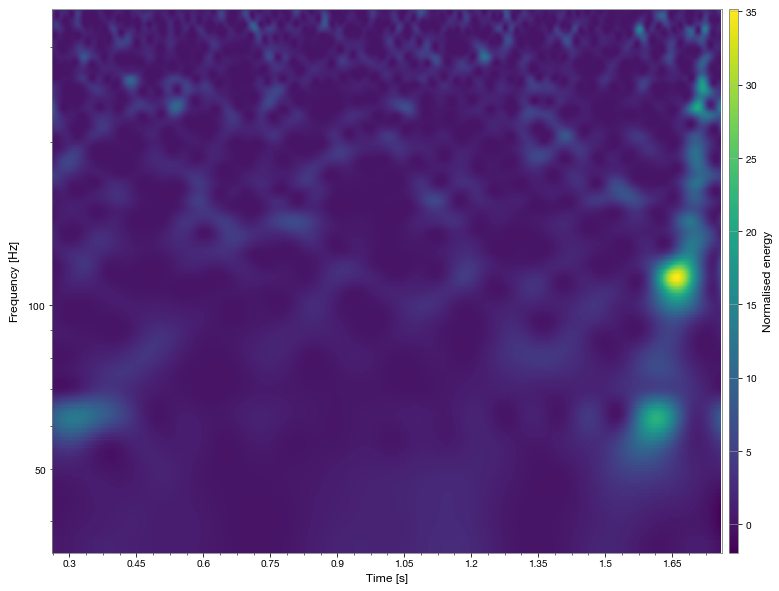

In [173]:
strain = read_data_id("000a5b6e5c")

processed_strain = preprocess(*strain, crop=True, bandpass=True)

hq = processed_strain[1].q_transform(qrange=(16,32), frange=(35,350), logf=True, whiten=False)
fig4 = hq.plot(figsize=[12, 10])
ax = fig4.gca()
fig4.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Time [s]');

# Image Creation

In [174]:
Q_RANGE = (16,32)
F_RANGE = (35,350)

def create_image(fname):
    strain = read_file(fname)
    
    processed_strain = preprocess(*strain, crop=True, bandpass=True)
    
    q_transforms = [strain.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False) 
                    for strain in processed_strain]
    
    img = np.zeros([q_transforms[0].shape[0], q_transforms[0].shape[1], 3], dtype=np.uint8)
    
    scaler = MinMaxScaler()
    
    for i in range(3):
        img[:, :, i] = 255 * scaler.fit_transform(q_transforms[i])
    
    return Image.fromarray(img).rotate(90, expand=1).resize((760, 760))

In [175]:
img = create_image(get_fname("000a5b6e5c"))

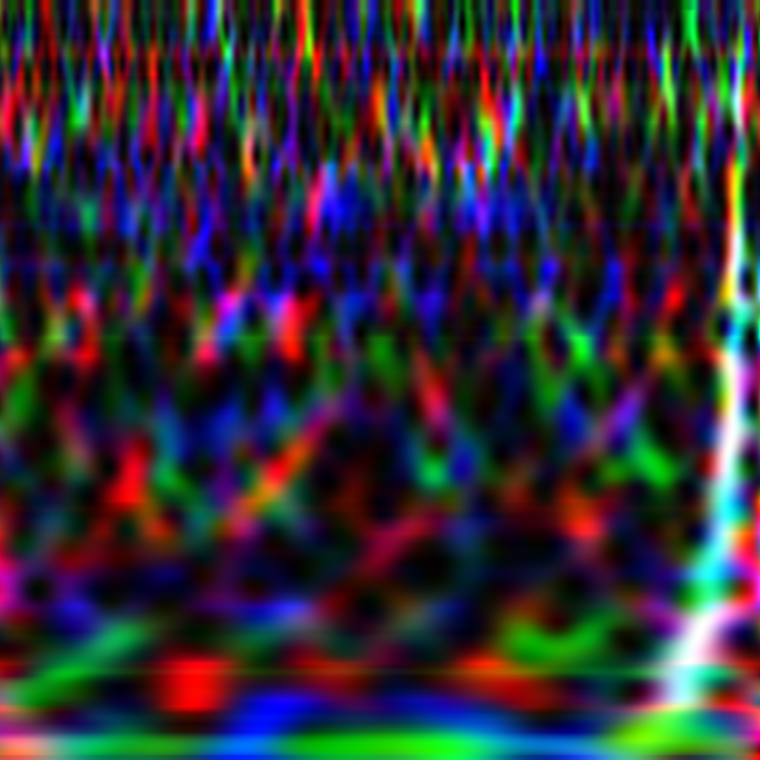

In [176]:
img

In [177]:
img.size

(760, 760)

In [125]:
arr[0]

array(['00000e74ad', 1,
       './g2net-gravitational-wave-detection/train/0/0/0/00000e74ad.npy'],
      dtype=object)